In [1]:
%load_ext autoreload
%autoreload 2
from astropy.table import Table
import pandas as pd
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import sys
from scipy import stats
from tqdm.auto import tqdm, trange
sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/modules/')
import model_halo_abundance as cl_count
import cluster_abundance_covariance as cl_covar
import cosmology
sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/modules/likelihood/')
import model_stacked_cluster_mass as cl_mass
sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/modules/sbi/')
import simulation as simulation
sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/pinocchio/')
import pinocchio_binning_scheme as binning_scheme
import pyccl as ccl
from multiprocessing import Pool
from matplotlib.cm import get_cmap
import pickle

def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Initialize SBI object

In [2]:
stacked_simulator_pl = simulation.Universe_simulation('stacked_counts',
                                                        variable_params=['omega_m', 
                                                                         'sigma_8', 
                                                                         'h',
                                                                         'alpha' , 
                                                                         'c' , 
                                                                         'beta',
                                                                         'sigma' ],
                                                        fixed_params={'w_0': -1, 'w_a': 0 } )
stacked_simulator_pl.selection_richness = 0
def dOmega_z(z): return 0.25 * 4 * np.pi
stacked_simulator_pl.dOmega = dOmega_z
stacked_simulator_pl.richness_bins = None
stacked_simulator_pl.redshift_bins = None
stacked_simulator_pl.sigma_mwl = 0
stacked_simulator_pl.include_mwl_measurement_errors = False
stacked_simulator_pl.correlation_mass_evolution = False
stacked_simulator_pl.set_richness_mass_relation( 'constantins model' )
stacked_simulator_pl.set_bins( z_bins = np.arange( 0.2 , 1 , 0.0005 ) , 
                               log10m_bins=  np.arange( 13.5 , 16 , 0.001))
stacked_simulator_pl.massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
stacked_simulator_pl.halobias_fct = ccl.halos.hbias.tinker10.HaloBiasTinker10(mass_def=stacked_simulator_pl.massdef)
stacked_simulator_pl.hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=stacked_simulator_pl.massdef)
stacked_simulator_pl.add_SSC = True
stacked_simulator_pl.use_hybrid = True
stacked_simulator_pl.Z_edges_hybrid = binning_scheme.redshift_edges
Z_bin_hybrid = [[stacked_simulator_pl.Z_edges_hybrid[i], stacked_simulator_pl.Z_edges_hybrid[i+1]] for i in range(len(stacked_simulator_pl.Z_edges_hybrid)-1)]


In [3]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711

cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

def compute_Sij_matrix(cosmo, Z_bin_hybrid, f_sky = 1):
    import cluster_abundance_covariance as cl_covar
    CLCovar = cl_covar.Covariance_matrix()
    Sij_partialsky_exact_standard = CLCovar.compute_theoretical_Sij(Z_bin_hybrid, cosmo, 
                                                                f_sky,
                                                                S_ij_type='full_sky_rescaled_approx', 
                                                                path=None)
    return Sij_partialsky_exact_standard

def compute_sigmaij_matrix(cosmo, z_grid, f_sky = 1):
    import cluster_abundance_covariance as cl_covar
    z_grid_center = np.array([(z_grid[i] + z_grid[i+1])/2 for i in range(len(z_grid)-1)])
    CLCovar = cl_covar.Covariance_matrix()
    sigmaij_partialsky_exact_standard = CLCovar.compute_theoretical_sigmaij(z_grid_center, cosmo, f_sky)
    return sigmaij_partialsky_exact_standard

# Compute (or load) fiducial Sij matrix

In [4]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711

cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

In [5]:
have_PySSC = False
f_sky = 0.25
if have_PySSC:
    z_grid = np.linspace(0.2, 1, 1000)
    stacked_simulator_pl.sigmaij_SSC = compute_sigmaij_matrix(cosmo, z_grid)/f_sky
    save_pickle(stacked_simulator_pl.sigmaij_SSC*f_sky, f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_matrix/sigma_ij_full_sky.pkl', )
    
    stacked_simulator_pl.Sij_SSC = compute_Sij_matrix(cosmo, Z_bin_hybrid)/f_sky
    save_pickle(stacked_simulator_pl.Sij_SSC*f_sky, f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_matrix/S_ij_full_sky.pkl', )
else: 
    S_ij_full_sky = load(f'/pbs/throng/lsst/users/cpayerne/capish/pinocchio/data/pinocchio_matrix/S_ij_full_sky.pkl' )
    stacked_simulator_pl.Sij_SSC = S_ij_full_sky/f_sky
    
    sigma_ij_full_sky = load(f'/pbs/throng/lsst/users/cpayerne/capish/pinocchio/data/pinocchio_matrix/sigma_ij_full_sky.pkl' )
    stacked_simulator_pl.sigmaij_SSC = sigma_ij_full_sky/f_sky


# Hybrid

In [6]:
stacked_simulator_pl.use_hybrid = True
%time Nth_hybrid, log10m_hybrid, z_hybrid = stacked_simulator_pl.get_halo_catalogue(cosmo, return_Nth = True)

CPU times: user 4.07 s, sys: 76.3 ms, total: 4.15 s
Wall time: 1.26 s


In [7]:
Ncount_obs_hybrid, a, b = np.histogram2d(z_hybrid, log10m_hybrid, bins = [binning_scheme.redshift_edges, binning_scheme.logm_edges])

# Unbinned

In [8]:
stacked_simulator_pl.use_hybrid = False
%time Nth_unbinned, log10m_unbinned, z_unbinned = stacked_simulator_pl.get_halo_catalogue(cosmo,return_Nth = True)

CPU times: user 6.55 s, sys: 2.78 s, total: 9.34 s
Wall time: 2.64 s


In [9]:
Ncount_obs_unbinned, a, b = np.histogram2d(z_unbinned, log10m_unbinned, bins = [binning_scheme.redshift_edges, binning_scheme.logm_edges])

In [10]:
Z_bin = binning_scheme.Z_bin
LogMass_bin = binning_scheme.LogMass_bin
Richness_bin = binning_scheme.Richness_bin

# Compare to standard approach

In [11]:
logm_edges = binning_scheme.logm_edges
redshift_edges = binning_scheme.redshift_edges
richness_edges = binning_scheme.richness_edges
Z_bin = binning_scheme.Z_bin
LogMass_bin = binning_scheme.LogMass_bin

In [12]:
CosmologyObject = cosmology.Cosmology(hmf =stacked_simulator_pl.hmd, bias_model=stacked_simulator_pl.halobias_fct )

In [13]:
clc = cl_count.HaloAbundance(CosmologyObject = CosmologyObject)
z_grid = np.linspace(0.2, 1., 1000)
logm_grid = np.linspace(13.5, 16, 2000)
clc.set_cosmology(cosmo = cosmo)
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
clc.compute_halo_bias_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
clc.sky_area = 0.25 * 4 * np.pi
Ncount_th = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = LogMass_bin, method = 'simps')
Nbias_th = clc.Nhalo_bias_MZ(Redshift_bin = Z_bin, Proxy_bin = LogMass_bin, method = 'simps')
Mass_th = clc.Cluster_NMass_MZ(Redshift_bin = Z_bin, Proxy_bin = LogMass_bin, method = 'simps')/Ncount_th
Mass_power_th = (clc.Cluster_NMass_MZ(Redshift_bin = Z_bin, Proxy_bin = LogMass_bin, method = 'simps', power = 1/3)/Ncount_th)**3

In [14]:
Mass_power_th/Mass_th

array([[0.99593553, 0.99593917, 0.99594396, 0.99595082, 0.99596049,
        0.99597407, 0.9959939 , 0.99602363, 0.99606826, 0.99613571,
        0.99623896, 0.99639724, 0.99663478, 0.99697793, 0.99744223],
       [0.99593874, 0.99594337, 0.99594953, 0.99595836, 0.99597087,
        0.99598858, 0.99601453, 0.99605347, 0.99611195, 0.99620014,
        0.99633404, 0.99653597, 0.99683112, 0.99724004, 0.99775996],
       [0.99594274, 0.99594864, 0.99595657, 0.99596794, 0.99598413,
        0.99600721, 0.99604114, 0.99609201, 0.99616829, 0.99628276,
        0.99645444, 0.99670775, 0.99706546, 0.99753593, 0.99809159],
       [0.99594762, 0.9959551 , 0.99596526, 0.99597984, 0.99600069,
        0.99603058, 0.99607457, 0.99614042, 0.99623876, 0.99638508,
        0.99660091, 0.99691054, 0.99732959, 0.99784783, 0.99841164],
       [0.99595349, 0.99596293, 0.99597585, 0.99599441, 0.99602104,
        0.99605937, 0.99611579, 0.99619992, 0.99632475, 0.99650822,
        0.99677308, 0.99714019, 0.9976126 , 

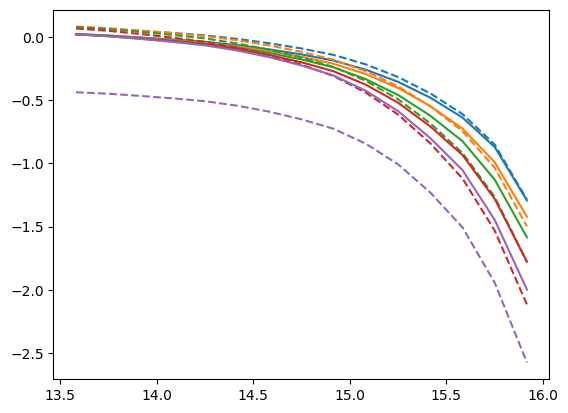

In [15]:
for i, z_bin in enumerate(Z_bin):
     Count_hybrid = []
     Count_unbinned = []
     for logmass_bin in LogMass_bin:
         mask_hybrid_m = (Nth_hybrid['logm_grid_center'] > logmass_bin[0])*(Nth_hybrid['logm_grid_center'] < logmass_bin[1])
         Count_hybrid.append(np.sum(Nth_hybrid['N_th'][i,:][mask_hybrid_m]))

         mask_unbinned_m = (Nth_unbinned['logm_grid_center'] > logmass_bin[0])*(Nth_unbinned['logm_grid_center'] < logmass_bin[1])
         mask_unbinned_z = (Nth_unbinned['z_grid_center'] > z_bin[0])*(Nth_unbinned['z_grid_center'] < z_bin[1])
         Count_unbinned.append(np.sum(Nth_unbinned['N_th'][:,mask_unbinned_z][mask_unbinned_m]))


     plt.plot(np.mean(LogMass_bin, axis=1), 100*(np.array(Count_hybrid) - Ncount_th[i,:])/Ncount_th[i,:],'C'+str(i), )
     plt.plot(np.mean(LogMass_bin, axis=1), 100*(np.array(Count_unbinned) - Ncount_th[i,:])/Ncount_th[i,:],'--C'+str(i) )
plt.plot([], [], '-k', label = 'Standard binned prediction (we trust it)')
plt.plot([], [], '+k', label = 'Sum of hybrid counts in mass-redshift bins')
plt.plot([], [], 'ok', label = 'Sum of unbinned counts in mass-redshift bins')


# Compare variance

In [16]:
CLCovar = cl_covar.Covariance_matrix()
NNSbb = CLCovar.sample_covariance_full_sky(Z_bin, LogMass_bin, Nbias_th, S_ij_full_sky/f_sky)
Cov_tot = NNSbb + np.diag(Ncount_th.flatten())

In [17]:
def _map_f(args):
    f, i = args
    return f(i)
def map(func, iter, ncores=3, ordered=True):
    
    ncpu = multiprocessing.cpu_count()
    print('You have {0:1d} CPUs'.format(ncpu))
    pool = multiprocessing.Pool(processes=ncpu) 
    inputs = ((func,i) for i in iter)
    res_list = []
    if ordered: pool_map = pool.imap
    else: pool_map = pool.imap_unordered
    with tqdm(total=len(iter), desc='# progress ...') as pbar:
        for res in pool_map(_map_f, inputs):
            try :
                pbar.update()
                res_list.append(res)
            except KeyboardInterrupt:
                pool.terminate()
    pool.close()
    pool.join()
    return res_list

In [18]:
def f(n, useSSC):
    np.random.seed(n)
    stacked_simulator_pl.add_SSC = useSSC
    stacked_simulator_pl.use_hybrid = False
    Nth_unbinned, log10m_unbinned, z_unbinned = stacked_simulator_pl.get_halo_catalogue(cosmo, return_Nth=True)
    Ncount_obs_unbinned, a, b = np.histogram2d(z_unbinned, log10m_unbinned, bins = [binning_scheme.redshift_edges, binning_scheme.logm_edges])
    Mean_mass= stats.binned_statistic_2d(z_unbinned,log10m_unbinned, 10**np.array(log10m_unbinned), 'mean',
                                              bins = [binning_scheme.redshift_edges, binning_scheme.logm_edges]).statistic
    Mean_mass_power= stats.binned_statistic_2d(z_unbinned,log10m_unbinned, (10**np.array(log10m_unbinned))**(1/3), 'mean',
                                              bins = [binning_scheme.redshift_edges, binning_scheme.logm_edges]).statistic
    return Ncount_obs_unbinned, Mean_mass, Mean_mass_power**3
def f_SSC(n): return f(n, True)
def f_noSSC(n): return f(n, False)

In [19]:
import multiprocessing
nsim = 400

In [20]:
res_SSC = map(f_SSC, np.arange(nsim), ncores=3, ordered=True)

You have 16 CPUs


# progress ...: 100%|██████████| 400/400 [07:36<00:00,  1.14s/it]


In [21]:
res_noSSC = map(f_noSSC, np.arange(nsim), ncores=3, ordered=True)

You have 16 CPUs


# progress ...: 100%|██████████| 400/400 [01:00<00:00,  6.56it/s]


In [22]:
Nres_SSC = []
Nres_noSSC = []
Mres_SSC = []
Mpower_SSC = []
for i in range(len(res_SSC)):
    Nres_noSSC.append(res_noSSC[i][0])
    Nres_SSC.append(res_SSC[i][0])
    Mres_SSC.append(res_SSC[i][1])
    Mpower_SSC.append(res_SSC[i][2])

Text(0.5, 0, '$\\log_{10}M$')

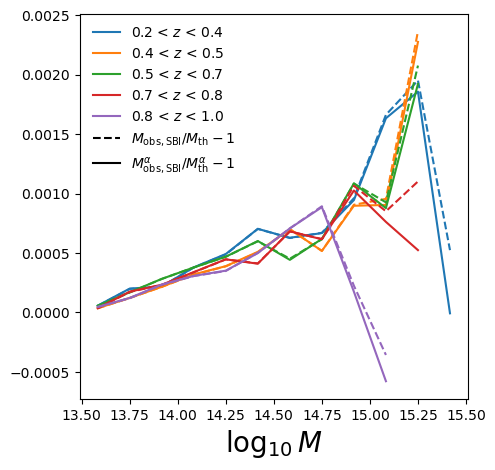

In [27]:
plt.figure(figsize=(5, 5))
for i, z_bin in enumerate(Z_bin):
    plt.plot(np.mean(LogMass_bin, axis=1), 
         (np.mean(np.array(Mres_SSC)[:,i,:], axis=0))/(Mass_th[i,:])-1, 
         'C'+str(i), ls = '-', markersize=15, label = f'{z_bin[0]:.1f} < $z$ < {z_bin[1]:.1f}')
    plt.plot(np.mean(LogMass_bin, axis=1), 
             (np.mean(np.array(Mpower_SSC)[:,i,:], axis=0))/(Mass_power_th[i,:])-1, 
             'C'+str(i), ls = '--', markersize=15,)
   
plt.plot([], [], '--k', label = r'$M_{\rm obs, SBI}/M_{\rm th} - 1$')
plt.plot([], [], '-k', label = r'$M_{\rm obs, SBI}^\alpha/M_{\rm th}^\alpha - 1$')

#plt.ylim(-.03,.03)
plt.legend(frameon=False)
plt.xlabel(r'$\log_{10}M$', fontsize=20,)

Text(0.5, 0, '$\\log_{10}M$')

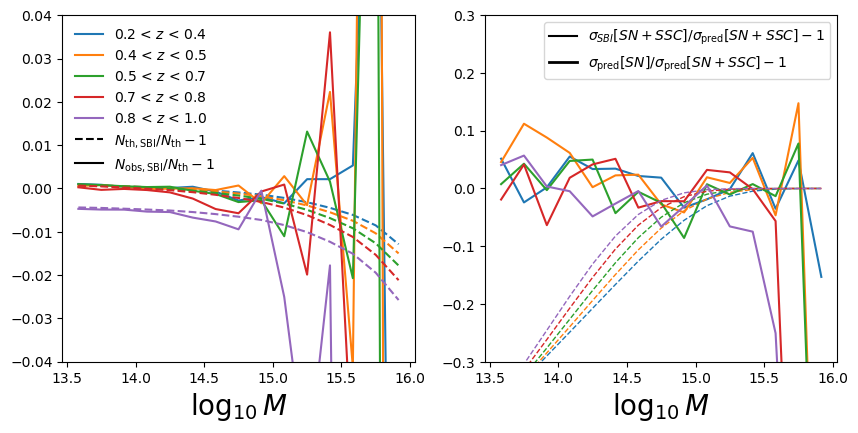

In [35]:
plt.figure(figsize=(10, 4.5))
plt.subplot(121)
for i, z_bin in enumerate(Z_bin):
    plt.plot(np.mean(LogMass_bin, axis=1), 
             (np.mean(np.array(Nres_SSC)[:,i,:], axis=0))/(Ncount_th[i,:])-1, 
             'C'+str(i), ls = '-', markersize=15, label = f'{z_bin[0]:.1f} < $z$ < {z_bin[1]:.1f}')
    Count_hybrid = []
    Count_unbinned = []
    for logmass_bin in LogMass_bin:

        mask_unbinned_m = (Nth_unbinned['logm_grid_center'] > logmass_bin[0])*(Nth_unbinned['logm_grid_center'] < logmass_bin[1])
        mask_unbinned_z = (Nth_unbinned['z_grid_center'] > z_bin[0])*(Nth_unbinned['z_grid_center'] < z_bin[1])
        Count_unbinned.append(np.sum(Nth_unbinned['N_th'][:,mask_unbinned_z][mask_unbinned_m]))

    plt.plot(np.mean(LogMass_bin, axis=1), (np.array(Count_unbinned) - Ncount_th[i,:])/Ncount_th[i,:],'--C'+str(i) )
plt.plot([], [], '--k', label = r'$N_{\rm th, SBI}/N_{\rm th} - 1$')
plt.plot([], [], '-k', label = r'$N_{\rm obs, SBI}/N_{\rm th} - 1$')

plt.ylim(-.04,.04)
plt.legend(frameon=False)
plt.xlabel(r'$\log_{10}M$', fontsize=20,)

plt.subplot(122)
for i, z_bin in enumerate(Z_bin):

    cov = Cov_tot.T.diagonal()[i*len(LogMass_bin):(i+1)*len(LogMass_bin)]

    plt.plot(np.mean(LogMass_bin, axis=1), 
             (Ncount_th[i,:]**.5)/(cov**.5)-1, 
             'C'+str(i), ls = '--', lw=1, markersize=15)
    
    plt.plot(np.mean(LogMass_bin, axis=1), 
             (np.std(np.array(Nres_SSC)[:,i,:], axis=0))/(cov**.5)-1, 
             'C'+str(i), ls = '-', markersize=15)
    #plt.plot(np.mean(LogMass_bin, axis=1), 
    #         (np.std(np.array(Nres_noSSC)[:,i,:], axis=0))/(cov**.5)-1, 
    #         'C'+str(i), ls = '--', markersize=15)
    plt.ylim(-.3,.3)


plt.plot([], [], '-k', label = r'$\sigma_{SBI}[SN+SSC]/\sigma_{\rm pred}[SN+SSC] - 1$')
plt.plot([], [], '-k', lw=2, label = r'$\sigma_{\rm pred}[SN]/\sigma_{\rm pred}[SN+SSC] - 1$')
#plt.plot([], [], '--k', lw=2, label = r'$\sigma_{SBI}[SN]/\sigma_{\rm pred}[SN+SSC] - 1$')
plt.legend()
plt.xlabel(r'$\log_{10}M$', fontsize=20,)